In [2]:
import requests
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset, load_metric


headers = {"x-api-key": 'zS5ZuEKrRZ6PZF3GHOTErudmnAclsFN37gYvaOkd'}
requests.get("https://api.semanticscholar.org/", headers = headers)


<Response [200]>

In [3]:
import time
journals = []
abstracts = []
titles = []
n_articles = 5000
baseurl = "https://api.semanticscholar.org/graph/v1/paper/search?query="
query = "Pain"
rest = "&limit=100&fields="
fields = "publicationTypes,journal,title,abstract"

for i in range(0,n_articles//100):
    offset = "&offset="+f"{i*100}"
    df = requests.get(baseurl+query+offset+rest+fields, headers = headers)
    print(df)
    time.sleep(2)
    for i in range(0,100):
        try:
            journals.append(df.json()["data"][i]["journal"]["name"])
            titles.append(df.json()["data"][i]["title"])
            abstracts.append(df.json()["data"][i]["abstract"])
            
        except:
            next

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


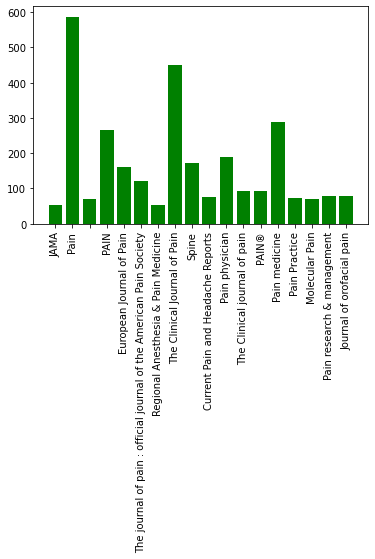

In [14]:
filter_value = 50
dictionary = Counter(journals)

filterddic = {k: v for k, v in dictionary.items() if v > filter_value}
plt.bar(list(filterddic.keys()), filterddic.values(), color='g')
plt.xticks(rotation=90)
plt.show()

In [16]:
import pandas as pd

data = pd.DataFrame(
    {'abstracts': abstracts,
     'journal': journals})

data = data.dropna()
data[data['journal'].str.strip().astype(bool)]

data["abstracts"] = data["abstracts"].str.lower()
data["journal"] = data["journal"].str.lower()
li = data['journal'].str.strip().astype(bool)


data = data.loc[li,:]

counts = data['journal'].value_counts()

journalz = counts.index[counts.values > 50]
data = data[data['journal'].isin(journalz)]


possible_labels = data.journal.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict
data['label'] = data.journal.replace(label_dict)


from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data.index.values, 
                                                  data.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=data.label.values)



data['data_type'] = ['not_set']*data.shape[0]

data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

data.groupby(['journal', 'label', 'data_type']).count()

abstracts
journal                      label data_type           
european journal of pain     2     train             88
                                   val               16
jama                         0     train             44
                                   val                8
journal of orofacial pain    10    train             65
                                   val               11
journal of pain research     3     train             45
                                   val                8
pain                         1     train            166
                                   val               30
pain medicine                7     train            248
                                   val               44
pain physician               5     train            160
                                   val               28
pain practice                8     train             63
                                   val               11
pain research & management   9     train             75
                                   val               13
spine                        4     train            148
                                   val               26
the clinical journal of pain 6     train            470
                                   val               83

In [17]:
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    data[data.data_type=='train'].abstracts.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    data[data.data_type=='val'].abstracts.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)






model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)


from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)



from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')




Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/jespere/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing 

In [18]:
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/home/jespere/NLP/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/524 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.902526515699525
Validation loss: 1.5320438088909272
F1 Score (Weighted): 0.45164313538390605


Epoch 2:   0%|          | 0/524 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.2266296911273749
Validation loss: 1.1551079785311094
F1 Score (Weighted): 0.5702590305330978


Epoch 3:   0%|          | 0/524 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.8097200064301378
Validation loss: 0.9354497098554206
F1 Score (Weighted): 0.6879621617814117


Epoch 4:   0%|          | 0/524 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5700598848230056
Validation loss: 0.8966150176060456
F1 Score (Weighted): 0.7170438658380639


Epoch 5:   0%|          | 0/524 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.46482505684519426
Validation loss: 0.9222885124104959
F1 Score (Weighted): 0.7260479256133067


In [19]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/home/jespere/NLP/finetuned_BERT_epoch_5.model', map_location=torch.device('cpu')))





_, predictions, true_vals = evaluate(dataloader_validation)

accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: jama
Accuracy: 6/8

Class: pain
Accuracy: 26/30

Class: european journal of pain
Accuracy: 12/16

Class: journal of pain research
Accuracy: 0/8

Class: spine
Accuracy: 26/26

Class: pain physician
Accuracy: 28/28

Class: the clinical journal of pain
Accuracy: 63/83

Class: pain medicine
Accuracy: 34/44

Class: pain practice
Accuracy: 2/11

Class: pain research & management
Accuracy: 4/13

Class: journal of orofacial pain
Accuracy: 5/11

